# Visualizing Layer Activations of MLP

#### This notebook shows a way to visualize the activations of a layer given an input to the network 
 
    - Data used to train the model is MNIST
    - The neural network is implemented with Pytorch

In [1]:
# Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from statistics import mean
import sys

%matplotlib inline

In [2]:
# Importing Data 
transformer = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))])

train_dataset = torchvision.datasets.MNIST(root = '../data', 
                            train=True, download=True,
                             transform=transformer)

valid_dataset = torchvision.datasets.MNIST(root = '../data', 
                                train=False, download=True,
                             transform=transformer)

In [3]:
# Generating Dataloaders
train_params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 1,
          'pin_memory' : True 
          }

valid_params = {'batch_size': 1000,
          'shuffle': True,
          'num_workers': 1,
          'pin_memory' : True
          }

train_loader = torch.utils.data.DataLoader(train_dataset,**train_params)

valid_loader = torch.utils.data.DataLoader(valid_dataset,**valid_params)

In [4]:
# Run on 'cuda' if available
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cuda'

In [5]:
# Network Class
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(28*28, 100)
        self.fc2 = nn.Linear(100,10)
            
    def forward(self, input):
        input = input.view(-1, 28*28)
        self.out1 = F.relu(self.fc1(input))
        self.out2 = F.relu(self.fc2(self.out1))
        return self.out2
    
    def execute_train(self, num_epochs, train_loader, opt, loss_fun):
        """
        Trains the model for the specified number of epochs
        """
        self.train()
        losses = []
        for epoch in range(1,num_epochs+1):
            batch_losses = []
            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(device), target.to(device)
                
                out = self(data)
                loss = loss_fun(out, target)
                
                batch_losses.append(loss.item())
                
                opt.zero_grad()
                loss.backward()
                opt.step()
            
            losses.append(mean(batch_losses))
                
            if epoch % 2 == 0:
                print('Epoch [{}/{}] Loss : {:.4f}'.format(epoch, num_epochs, losses[epoch-1]))
        
        return losses
    
    def visualize_activations(self, data, path = 'activation_images/', save_fig_name = '1', show = False):
        """
        Plots input, layer activations, predicted output in one plot
        """
        fig, axs = plt.subplots(1,4, figsize=(10,12))
        for ax in axs:
            ax.axis('off')

        with torch.no_grad():
            self.forward(data)

        data = data.squeeze(0).cpu().numpy()
        self.out1 = self.out1.squeeze(0).squeeze(0).cpu().numpy().reshape(100,1)
        self.out2 = self.out2.squeeze(0).squeeze(0).cpu().numpy().reshape(10,1)
        actual_out = np.where(self.out2 == max(self.out2))[0][0]

        axs[0].imshow(data,cmap='gist_gray',aspect=1)
        axs[0].set_title('Input')
        axs[1].imshow(self.out1, cmap='gist_gray',aspect=0.1)
        axs[1].set_title('Hidden Layer activations')
        axs[2].imshow(self.out2, cmap='gist_gray',aspect=0.09)
        axs[2].set_title('Output Layer activations')
        axs[3].text(0.3, 0.5, str(actual_out), fontsize=15)
        axs[3].text(0.1, 0.6, 'Predicted', fontsize=12)
        plt.savefig(str(path)+str(save_fig_name)+'.png')
        if show:
            plt.show()
        plt.clf()


###### Initializing the model

In [6]:
net = Network().to(device)
net

Network(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

###### Declaring the optimizer and loss function to be used

In [7]:
opt_sgd = torch.optim.Adam(net.parameters(), lr = 0.001)

In [8]:
loss_fun = nn.CrossEntropyLoss()

##### Training the model

    Also there is a saved version of the state dictionary of the model, which can be used if you don't want to wait for the model to be trained

In [9]:
train_losses = net.execute_train(50, train_loader, opt_sgd, loss_fun)

Epoch [2/50] Loss : 0.5814
Epoch [4/50] Loss : 0.5316
Epoch [6/50] Loss : 0.5115
Epoch [8/50] Loss : 0.4971
Epoch [10/50] Loss : 0.4894
Epoch [12/50] Loss : 0.4840
Epoch [14/50] Loss : 0.4809
Epoch [16/50] Loss : 0.4782
Epoch [18/50] Loss : 0.4756
Epoch [20/50] Loss : 0.4758
Epoch [22/50] Loss : 0.4743
Epoch [24/50] Loss : 0.4744
Epoch [26/50] Loss : 0.4752
Epoch [28/50] Loss : 0.4730
Epoch [30/50] Loss : 0.4715
Epoch [32/50] Loss : 0.4702
Epoch [34/50] Loss : 0.4723
Epoch [36/50] Loss : 0.4723
Epoch [38/50] Loss : 0.4721
Epoch [40/50] Loss : 0.4704
Epoch [42/50] Loss : 0.4718
Epoch [44/50] Loss : 0.4712
Epoch [46/50] Loss : 0.4706
Epoch [48/50] Loss : 0.4716
Epoch [50/50] Loss : 0.4698


#### Models state dictionary i.e. weights and biases are stored into file 'model_state_dict'

In [19]:
torch.save(net.state_dict(), 'model_state_dict')

# If you want to skip the training
#### Just load the state dictionary into the model
##### but before that initialize the model with the Network class defined above

In [20]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

model = Network()
model.load_state_dict(torch.load('model_state_dict', map_location=device))

<All keys matched successfully>

In [12]:
def get_random_data(dataset):
    """
    Gets a random data from the dataset provided
    """
    i = np.random.randint(100)
    data = dataset[i][0]
    return data

#### Calling the visualize activations method of the model and giving a random image from the validation data 

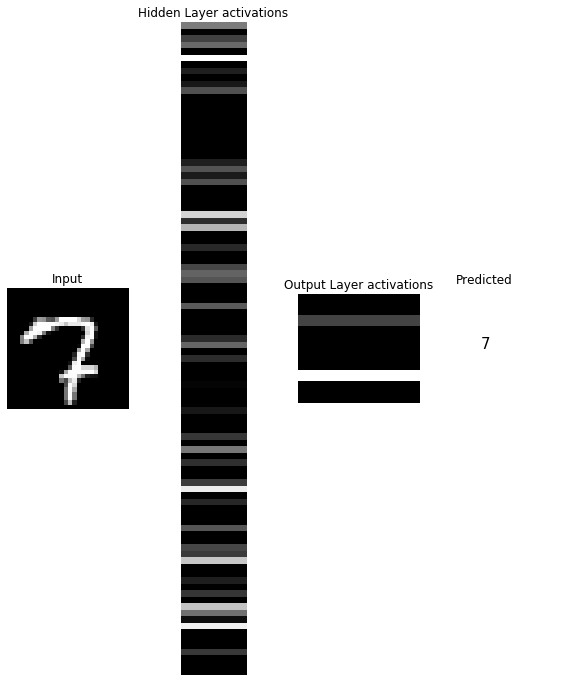

<Figure size 432x288 with 0 Axes>

In [13]:
model.visualize_activations(get_random_data(valid_dataset), 1, show = True)

### If you are interested in showing these visualizations as a video, this part is for you!

##### First run the visualize method for desired number of times and make sure that these are saved in desired folder

In [14]:
for i in range(15):
    model.visualize_activations(get_random_data(valid_dataset), path = 'activation_images/', save_fig_name = i, show = False)

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

#### Load all the images  into a list

In [22]:
import cv2
import glob

# path = 'path to the folder images are stored'
path = 'activation_images'

img_array = []
for filename in glob.glob( path +'/*.png'):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

###### To see the number of images loaded into the list 

In [23]:
len(img_array)

15

#### Now generate a video of desired frame rate

In [26]:

out = cv2.VideoWriter('activations_video.avi',cv2.VideoWriter_fourcc(*'DIVX'), 1, size)

for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [27]:
from IPython.display import Video
Video("activations_video.avi")